In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/1021.JPG.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/3090.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/2072.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/5097.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/3013.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/3074.JPG.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/1089.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/1083.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/5071.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/5074.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/2096.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/2050.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/4065.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF BLOTCH/4027.jpg.jpeg
/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF B

In [2]:
import cv2, os, shutil, math
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [3]:
sdir = '/kaggle/input/d-kap/APPLE_DISEASE_DATASET/'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    
    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count


train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

SCAB LEAVES            : 100%|████████████████████████████████████████████| 159/159 [00:02<00:00, 78.41file/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  127   the minimum files in any class in train_df is  37
train_df length:  335   test_df length:  42   valid_df length:  42
average image height=  727   average image width=  406  aspect ratio h/w=  1.79064039408867


In [4]:
train_df

,filepaths,labels
376,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
12,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
278,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
225,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
120,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/HEAL...,HEALTHY LEAVES
...,...,...
362,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
275,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
0,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
81,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES


In [5]:
test_df

,filepaths,labels
240,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
366,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
104,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/HEAL...,HEALTHY LEAVES
49,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
100,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
110,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/HEAL...,HEALTHY LEAVES
36,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
247,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
167,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
289,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES


In [6]:
valid_df

,filepaths,labels
299,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
354,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
350,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
206,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
388,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
406,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
32,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
86,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
78,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
151,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH


In [7]:
test_df

,filepaths,labels
240,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
366,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
104,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/HEAL...,HEALTHY LEAVES
49,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
100,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
110,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/HEAL...,HEALTHY LEAVES
36,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
247,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
167,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
289,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES


In [8]:
classes

['APPLE ROT LEAVES', 'HEALTHY LEAVES', 'LEAF BLOTCH', 'SCAB LEAVES']

In [9]:
class_count

4

In [10]:
n=200
batch_size = 32
working_dir=r'./'
img_size=(300, 300)
epochs = 50
input_shape = (300, 300, 3)

def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)

    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    
    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, zoom_range=0.2)
    groups = df.groupby('labels')
    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            msg = '{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')  # prints over on the same line
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=batch_size, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    print('Total Augmented images created= ', total)
    aug_fpaths, aug_labels = [], []
    classlist = os.listdir(aug_dir)
    for target in classlist:
        classpath = os.path.join(aug_dir, target)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(target)
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is ', len(df))
    return df


train_df = balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  335
Found 127 validated image filenames.
Found 82 validated image filenames.
Found 89 validated image filenames.
Found 37 validated image filenames.
Total Augmented images created=  543
Length of augmented dataframe is  878


In [11]:
train_df

,filepaths,labels
0,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
1,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/APPL...,APPLE ROT LEAVES
2,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/SCAB...,SCAB LEAVES
3,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/LEAF...,LEAF BLOTCH
4,/kaggle/input/d-kap/APPLE_DISEASE_DATASET/HEAL...,HEALTHY LEAVES
...,...,...
873,./aug/SCAB LEAVES/aug-_4_2272769.jpg,SCAB LEAVES
874,./aug/SCAB LEAVES/aug-_75_3306390.jpg,SCAB LEAVES
875,./aug/SCAB LEAVES/aug-_83_4385542.jpg,SCAB LEAVES
876,./aug/SCAB LEAVES/aug-_48_691687.jpg,SCAB LEAVES


In [12]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 878 validated image filenames belonging to 4 classes.
Found 42 validated image filenames belonging to 4 classes.
Found 42 validated image filenames belonging to 4 classes.
test batch size:  42 test steps:  1 number of classes :  4


In [13]:
def h_sigmoid(x):
    res = tf.nn.relu6(x + 3) / 6
    return res

def h_swish(x):
    res = x * h_sigmoid(x)
    return res


# Squeeze-and-Excitation Networks (SENets) introduce a building block for CNNs that improves channel interdependencies 
# at almost no computational cost. They were used at this years ImageNet competition and helped to improve the result 
# from last year by 25%. Besides this huge performance boost, they can be easily added to existing architectures. 
# Let’s add parameters to each channel of a convolutional block so that the network can adaptively adjust the weighting 
# of each feature map.

class SEBlock(tf.keras.layers.Layer):
    def __init__(self, input_channels, r=16):
        super(SEBlock, self).__init__()
        self.P1 = GlobalAveragePooling2D()
        self.D1 = Dense(input_channels // r)
        self.A1 = Activation('relu')
        self.D2 = Dense(input_channels)


    def call(self, inputs, **kwargs):
        branch = self.P1(inputs)
        branch = self.D1(branch)
        branch = self.A1(branch)
        branch = self.D2(branch)
        branch = h_sigmoid(branch)
        branch = tf.expand_dims(input=branch, axis=1)
        branch = tf.expand_dims(input=branch, axis=1)
        y = inputs * branch
        return y

# A bottleneck layer is a layer that contains few nodes compared to the previous layers. 
# It can be used to obtain a representation of the input with reduced dimensionality.
# The use of a bottleneck reduces the number of parameters and matrix multiplications. 
# The idea is to make residual blocks as thin as possible to increase depth and have less parameters. 
# They were introduced as part of the ResNet architecture, and are used as part of deeper ResNets such 
# as ResNet-50 and ResNet-101.

class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, in_size, exp_size, out_size, s, is_se_existing, NL, k):
        super(BottleNeck, self).__init__()
        self.stride = s
        self.in_size = in_size
        self.out_size = out_size
        self.is_se_existing = is_se_existing
        self.NL = NL

        self.C1 = Conv2D(filters=exp_size, kernel_size=(1, 1), strides=1, padding='same')
        self.B1 = BatchNormalization()

        self.DWC1 = DepthwiseConv2D(kernel_size=(k, k), strides=s, padding='same')
        self.B2 = BatchNormalization()

        self.se = SEBlock(input_channels=exp_size)
        self.C2 = Conv2D(filters=out_size, kernel_size=(1, 1), strides=1, padding='same')
        self.B3 = BatchNormalization()
        self.linear = Activation(tf.keras.activations.linear)

    def call(self, inputs, training=None, **kwargs):
        x = self.C1(inputs)
        x = self.B1(x, training=training)

        if self.NL == 'HS':
            x = h_swish(x)
        elif self.NL == 'RE':
            x = tf.nn.relu6(x)

        x = self.DWC1(x)
        x = self.B2(x, training=training)

        if self.NL == 'HS':
            x = h_swish(x)
        elif self.NL == 'RE':
            x = tf.nn.relu6(x)

        if self.is_se_existing:
            x = self.se(x)

        x = self.C2(x)
        x = self.B3(x)
        y = self.linear(x)

        if self.stride == 1 and self.in_size == self.out_size:
            y = add([y, inputs])
        return y

In [14]:
class MobileNetV3Small(tf.keras.layers.Layer):
    def __init__(self, input_shape):
        super(MobileNetV3Small, self).__init__()
        self.C1 = Conv2D(filters=16, kernel_size=(3, 3), strides=2, padding="same", input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.bneck1 = BottleNeck(in_size=16, exp_size=16, out_size=16, s=2, is_se_existing=True, NL="RE", k=3)
        self.bneck2 = BottleNeck(in_size=16, exp_size=72, out_size=24, s=2, is_se_existing=False, NL="RE", k=3)
        self.bneck3 = BottleNeck(in_size=24, exp_size=88, out_size=24, s=1, is_se_existing=False, NL="RE", k=3)
        self.bneck4 = BottleNeck(in_size=24, exp_size=96, out_size=40, s=2, is_se_existing=True, NL="HS", k=5)
        self.bneck5 = BottleNeck(in_size=40, exp_size=240, out_size=40, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck6 = BottleNeck(in_size=40, exp_size=240, out_size=40, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck7 = BottleNeck(in_size=40, exp_size=120, out_size=48, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck8 = BottleNeck(in_size=48, exp_size=144, out_size=48, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck9 = BottleNeck(in_size=48, exp_size=288, out_size=96, s=2, is_se_existing=True, NL="HS", k=5)
        self.bneck10 = BottleNeck(in_size=96, exp_size=576, out_size=96, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck11 = BottleNeck(in_size=96, exp_size=576, out_size=96, s=1, is_se_existing=True, NL="HS", k=5)

        self.C2 = Conv2D(filters=576,
                            kernel_size=(1, 1),
                            strides=1,
                            padding="same")
        self.B2 = BatchNormalization()
        self.P1 = AveragePooling2D(pool_size=(7, 7), strides=1)

        self.C3 = Conv2D(filters=1280, kernel_size=(1, 1), strides=1, padding="same")

        self.C4 = Conv2D(filters=1024, kernel_size=(1, 1), strides=1, padding="same", activation='softmax')

        self.P2 = GlobalAveragePooling2D()
        

    def call(self, inputs, training=None, mask=None):
        x = self.C1(inputs)
        x = self.B1(x, training=training)
        x = h_swish(x)

        x = self.bneck1(x, training=training)
        x = self.bneck2(x, training=training)
        x = self.bneck3(x, training=training)
        x = self.bneck4(x, training=training)
        x = self.bneck5(x, training=training)
        x = self.bneck6(x, training=training)
        x = self.bneck7(x, training=training)
        x = self.bneck8(x, training=training)
        x = self.bneck9(x, training=training)
        x = self.bneck10(x, training=training)
        x = self.bneck11(x, training=training)

        x = self.C2(x)
        x = self.B2(x, training=training)
        x = h_swish(x)
        x = self.P1(x)
        x = self.C3(x)
        x = h_swish(x)
        x = self.C4(x)
        y = self.P2(x)
        return y

In [15]:
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
    return res


# 定义残差MLP结构块
class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output


# ResMLP网络结构
class ResMLP(tf.keras.layers.Layer):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2

        self.D2 = Dense(num_classes, activation='softmax')


    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y

In [16]:
class NeuralNetwork(tf.keras.Model):
    def __init__(self, input_shape, initial_filters, block_list, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = MobileNetV3Small(input_shape=input_shape)
        self.layer2 = ResMLP(initial_filters=initial_filters, block_list=block_list, num_classes=num_classes)
        
    def call(self, x):
        x = self.layer1(x)
        y = self.layer2(x)
        return y

In [17]:
net = NeuralNetwork(input_shape=input_shape, initial_filters=32, block_list=[2, 2, 2], num_classes=4)
net.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['AUC'])

# checkpoint_save_path = './checkpoint/ResMLP.ckpt'
# if os.path.exists(checkpoint_save_path + '.index'):
#     print('-------------------------------------Loading-------------------------------------')
#     net.load_weights(checkpoint_save_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
#                               save_weights_only=True,
#                               save_best_only=True)

history = net.fit(train_ds, epochs=50, batch_size=batch_size, validation_data=valid_ds)

net.summary()

2022-09-27 08:46:43.128434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 08:46:43.243572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 08:46:43.244339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 08:46:43.246049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50
28/28 [==============================] - 16s 280ms/step - loss: 1.3053 - auc: 0.6296 - val_loss: 1.3706 - val_auc: 0.5595
Epoch 2/50
28/28 [==============================] - 6s 223ms/step - loss: 1.1368 - auc: 0.7344 - val_loss: 1.4046 - val_auc: 0.3651
Epoch 3/50
28/28 [==============================] - 6s 211ms/step - loss: 1.1077 - auc: 0.7547 - val_loss: 1.4025 - val_auc: 0.4563
Epoch 4/50
28/28 [==============================] - 7s 238ms/step - loss: 1.0831 - auc: 0.7583 - val_loss: 1.3639 - val_auc: 0.5794
Epoch 5/50
28/28 [==============================] - 6s 216ms/step - loss: 1.0642 - auc: 0.7740 - val_loss: 1.3578 - val_auc: 0.5794
Epoch 6/50
28/28 [==============================] - 6s 228ms/step - loss: 1.0048 - auc: 0.8033 - val_loss: 1.3630 - val_auc: 0.5794
Epoch 7/50
28/28 [==============================] - 6s 219ms/step - loss: 0.9968 - auc: 0.8033 - val_loss: 1.3449 - val_auc: 0.5397
Epoch 8/50
28/28 [==============================] - 6s 215ms/step - loss: 0

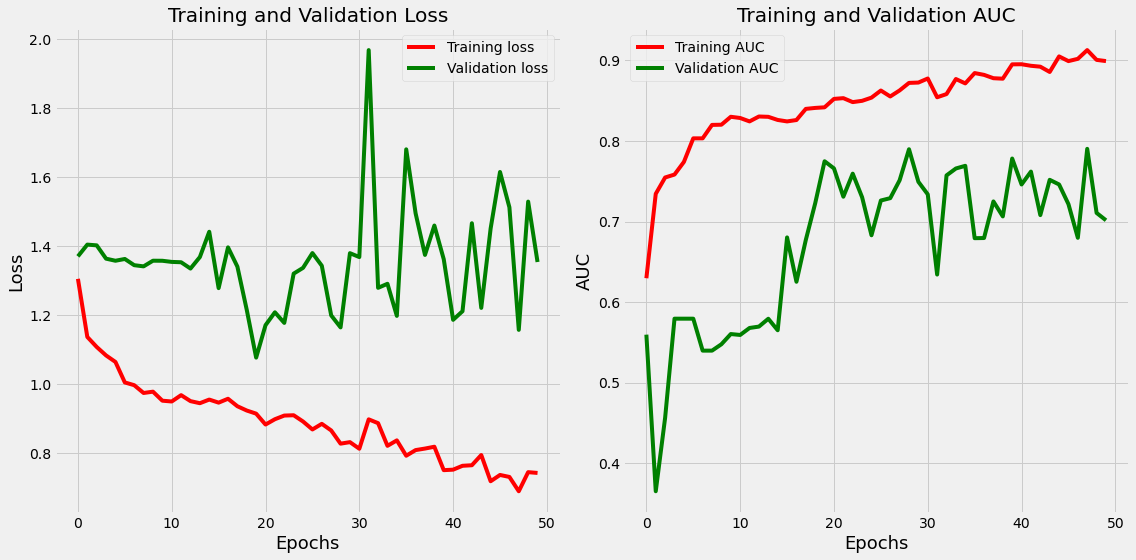

In [18]:
def plot_auc_loss(history, epochs):
    tloss = history.history['loss']
    tauc = history.history['auc']

    vloss = history.history['val_loss']
    vauc = history.history['val_auc']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(Epochs, tauc, 'r', label='Training AUC')
    axes[1].plot(Epochs, vauc, 'g', label='Validation AUC')
    axes[1].set_title('Training and Validation AUC')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('AUC', fontsize=18)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return Epochs


Epochs = plot_auc_loss(history, epochs)

there were 25 errors in 42 tests for an accuracy of  40.48%


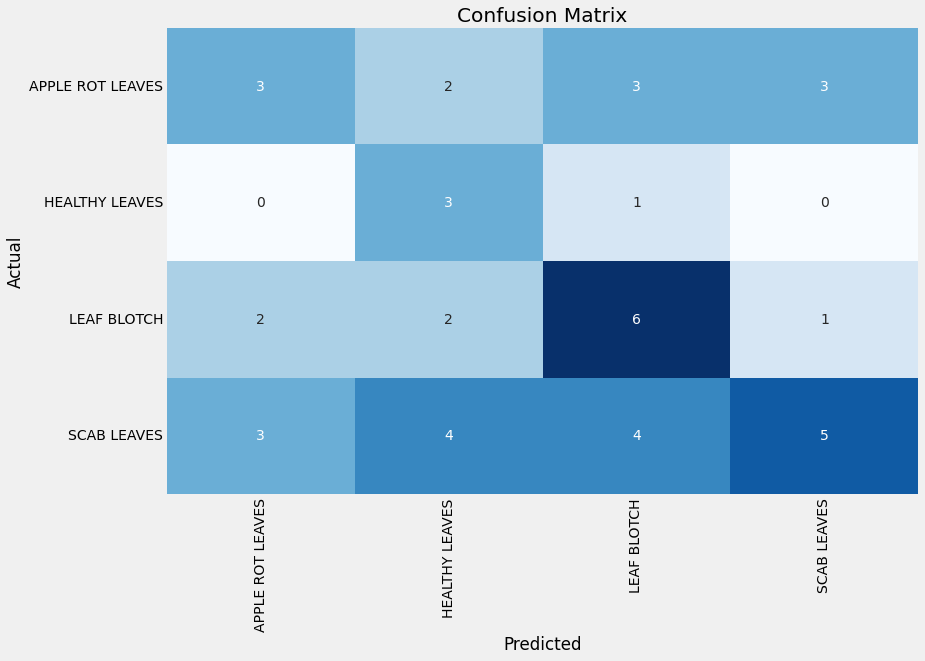

Classification Report:
----------------------
                   precision    recall  f1-score   support

APPLE ROT LEAVES     0.3750    0.2727    0.3158        11
  HEALTHY LEAVES     0.2727    0.7500    0.4000         4
     LEAF BLOTCH     0.4286    0.5455    0.4800        11
     SCAB LEAVES     0.5556    0.3125    0.4000        16

        accuracy                         0.4048        42
       macro avg     0.4080    0.4702    0.3989        42
    weighted avg     0.4481    0.4048    0.3989        42



In [19]:
def predictor(test_ds):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = tf.argmax(net.predict(test_ds), axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)